# Estimate ΔG

In [1]:
from pathlib import Path
import os
import json

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy

from cinnabar import FEMap, plotlying, plotting #, stats

import utils

In [2]:
def ddG_2_dG(edge_df: pd.DataFrame, exp_df: pd.DataFrame, protein_df: pd.DataFrame, water_df: pd.DataFrame, output_csv: Path|str = "/dev/shm/tmp.csv"):
    """
    Prepare a CSV file for Cinnabar Cycle Closure.
    
    Parameters
    ----------
    edge_df :
        This DataFrame should contain edge_name as index, and Lig_1, Lig_2

    exp_df : pd.DataFrame
        This DataFrame should contain Lig_Name as index, and Exp_dG

    protein_df :
        This DataFrame should contain edge_name as index, and ddG, ddG_err

    water_df :
        This DataFrame should contain edge_name as index, and ddG, ddG_err

    output_csv :
        Path to the temporary CSV file.

    """
    # ddG
    ddG_dict = {"edge_name"   :[],
                "calc_ddG"    :[],
                "calc_ddG_err":[],
                "Exp_ddG"     :[],
               }
    for edge_name in edge_df.index:
        ddG_dict["edge_name"   ].append(edge_name)
        ddG_dict["calc_ddG"    ].append(protein_df.loc[edge_name, "ddG"] - water_df.loc[edge_name, "ddG"])
        ddG_dict["calc_ddG_err"].append(np.sqrt(protein_df.loc[edge_name, "ddG_err"]**2 + water_df.loc[edge_name, "ddG_err"]**2))
        ddG_dict["Exp_ddG"     ].append(edge_df.loc[edge_name, "Exp_ddG"])
    ddG_df = pd.DataFrame(ddG_dict)
    ddG_df.set_index("edge_name")
    
    # dG
    utils.prepare_cinnabar_csv(edge_df, exp_df, protein_df, water_df, output_csv)
    fe = FEMap.from_csv(output_csv)
    fe.generate_absolute_values()
    df_abs = fe.get_absolute_dataframe()

    df_abs_com = df_abs[df_abs["computational"]== True]
    df_abs_exp = df_abs[df_abs["computational"]== False]
    df_abs_com = df_abs_com.set_index("label")
    df_abs_exp = df_abs_exp.set_index("label")
    
    df_abs_com["DG (kcal/mol)"] += df_abs_exp.loc[df_abs_exp.index, "DG (kcal/mol)"].mean() - df_abs_com.loc[df_abs_exp.index, "DG (kcal/mol)"].mean()
    
    exp_list = []
    for lig in df_abs_com.index:
        if lig in df_abs_exp.index:
            exp_list.append(df_abs_exp.loc[lig, "DG (kcal/mol)"])
        else:
            exp_list.append(None)
    df_abs_com["Exp_dG"] = exp_list
    return df_abs_com, ddG_df

# 1. Load Data

In [3]:
# point this to your folder
base = Path("/home/chui/E29Project-2023-04-11/136-grandFEP/benchmark/08-Water-Set/Benchmark_waterSet_2025_10_01/sim")

dG_dict = {}
ddG_dict = {}

for system in ["hspw", "hspk"]:
    system_base = base / system
    
    edge_df = pd.read_csv(system_base / "edge.csv", index_col="edge_name")
    exp_df = pd.read_csv(system_base / "lig.csv", index_col="Lig_Name")
    
    for ff in ["04_tip3p_REST2", ]: # ["opc_REST2", "tip3p_REST2"]
        reps = [f"{ff}/water/NPT/rep_{rep}/mbar/bar.log" for rep in range(3)]
        wat_df = utils.read_ddG_edges(edge_df.index, system_base, reps)
        for sim_length in [5, 10]:
            for prot in ["GC_80l_40MD_31RE_200MD"]: # "GC_80l_40MD_31RE_200MD", "GC_80l_40MD_15RE_200MD", "NPT_prod"
                reps = [f"{ff}/protein/{prot}/rep_{rep}/mbar_{sim_length}ns/mbar.log" for rep in range(3)]
                pro_df = utils.read_ddG_edges(edge_df.index, system_base, reps)
                dG_df, ddG_df = ddG_2_dG(edge_df,exp_df,pro_df,wat_df)
                dG_dict[ f"{system}_{ff}_{prot}_{sim_length}ns"] = dG_df
                ddG_dict[f"{system}_{ff}_{prot}_{sim_length}ns"] = ddG_df

/home/chui/Software-2023-04-11/miniforge3/envs/openfe_env/lib/python3.12/site-packages/cinnabar/femap.py:35: UserWarning: Assuming kcal/mol units on measurements
  warnings.warn("Assuming kcal/mol units on measurements")
/home/chui/Software-2023-04-11/miniforge3/envs/openfe_env/lib/python3.12/site-packages/cinnabar/femap.py:35: UserWarning: Assuming kcal/mol units on measurements
  warnings.warn("Assuming kcal/mol units on measurements")
/home/chui/Software-2023-04-11/miniforge3/envs/openfe_env/lib/python3.12/site-packages/cinnabar/femap.py:35: UserWarning: Assuming kcal/mol units on measurements
  warnings.warn("Assuming kcal/mol units on measurements")
/home/chui/Software-2023-04-11/miniforge3/envs/openfe_env/lib/python3.12/site-packages/cinnabar/femap.py:35: UserWarning: Assuming kcal/mol units on measurements
  warnings.warn("Assuming kcal/mol units on measurements")


# 2. Plot

In [21]:
def get_stat(df):
    rmsd, rmsd_bs = utils.get_stat_bootstrap(df["DG (kcal/mol)"], df["Exp_dG"], utils.rmsd_stat)
    tau,  tau_bs  = utils.get_stat_bootstrap(df["DG (kcal/mol)"], df["Exp_dG"], utils.kendall_stat)
    return (rmsd, rmsd_bs), (tau,  tau_bs)

def label_stat(df_res_all, axes):
    for df_list, ax_list in zip(df_res_all, axes):
        for df, ax in zip(df_list, ax_list):
            (rmsd, rmsd_bs), (tau,  tau_bs) = get_stat(df)
            ci_l, ci_h = rmsd_bs.confidence_interval
            text = r"$rmse={:.2f}^{{{:.2f}}}_{{{:.2f}}}$".format(rmsd, ci_h, ci_l)
            text += "\n"
            ci_l, ci_h = tau_bs.confidence_interval
            if np.any(np.isnan([ci_l, ci_h])):
                text += r"$\tau={:.2f}^{{{:.2f}}}_{{{:.2f}}}$".format(tau, tau, tau)
            else:
                text += r"$\tau={:.2f}^{{{:.2f}}}_{{{:.2f}}}$".format(tau, ci_h, ci_l)
                
            xmin, xmax = ax.get_xlim()
            ymin, ymax = ax.get_ylim()
            ax.text(
                xmin + (xmax - xmin)*0.05, 
                ymax - (ymax - ymin)*0.05,
                text, 
                verticalalignment = "top",
                bbox=dict(facecolor='white', alpha=1.0)
               )

In [22]:
[i for i in dG_dict]

['hspw_04_tip3p_REST2_GC_80l_40MD_31RE_200MD_5ns',
 'hspw_04_tip3p_REST2_GC_80l_40MD_31RE_200MD_10ns',
 'hspk_04_tip3p_REST2_GC_80l_40MD_31RE_200MD_5ns',
 'hspk_04_tip3p_REST2_GC_80l_40MD_31RE_200MD_10ns']

## 2.1. ΔG

/home/chui/Software-2023-04-11/miniforge3/envs/openfe_env/lib/python3.12/site-packages/scipy/stats/_resampling.py:147: RuntimeWarning: invalid value encountered in scalar divide
  a_hat = 1/6 * sum(nums) / sum(dens)**(3/2)
/home/chui/E29Project-2023-04-11/136-grandFEP/GrandFEP/test/hspw_tutorial/analysis/utils.py:293: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
  res = scipy.stats.bootstrap(


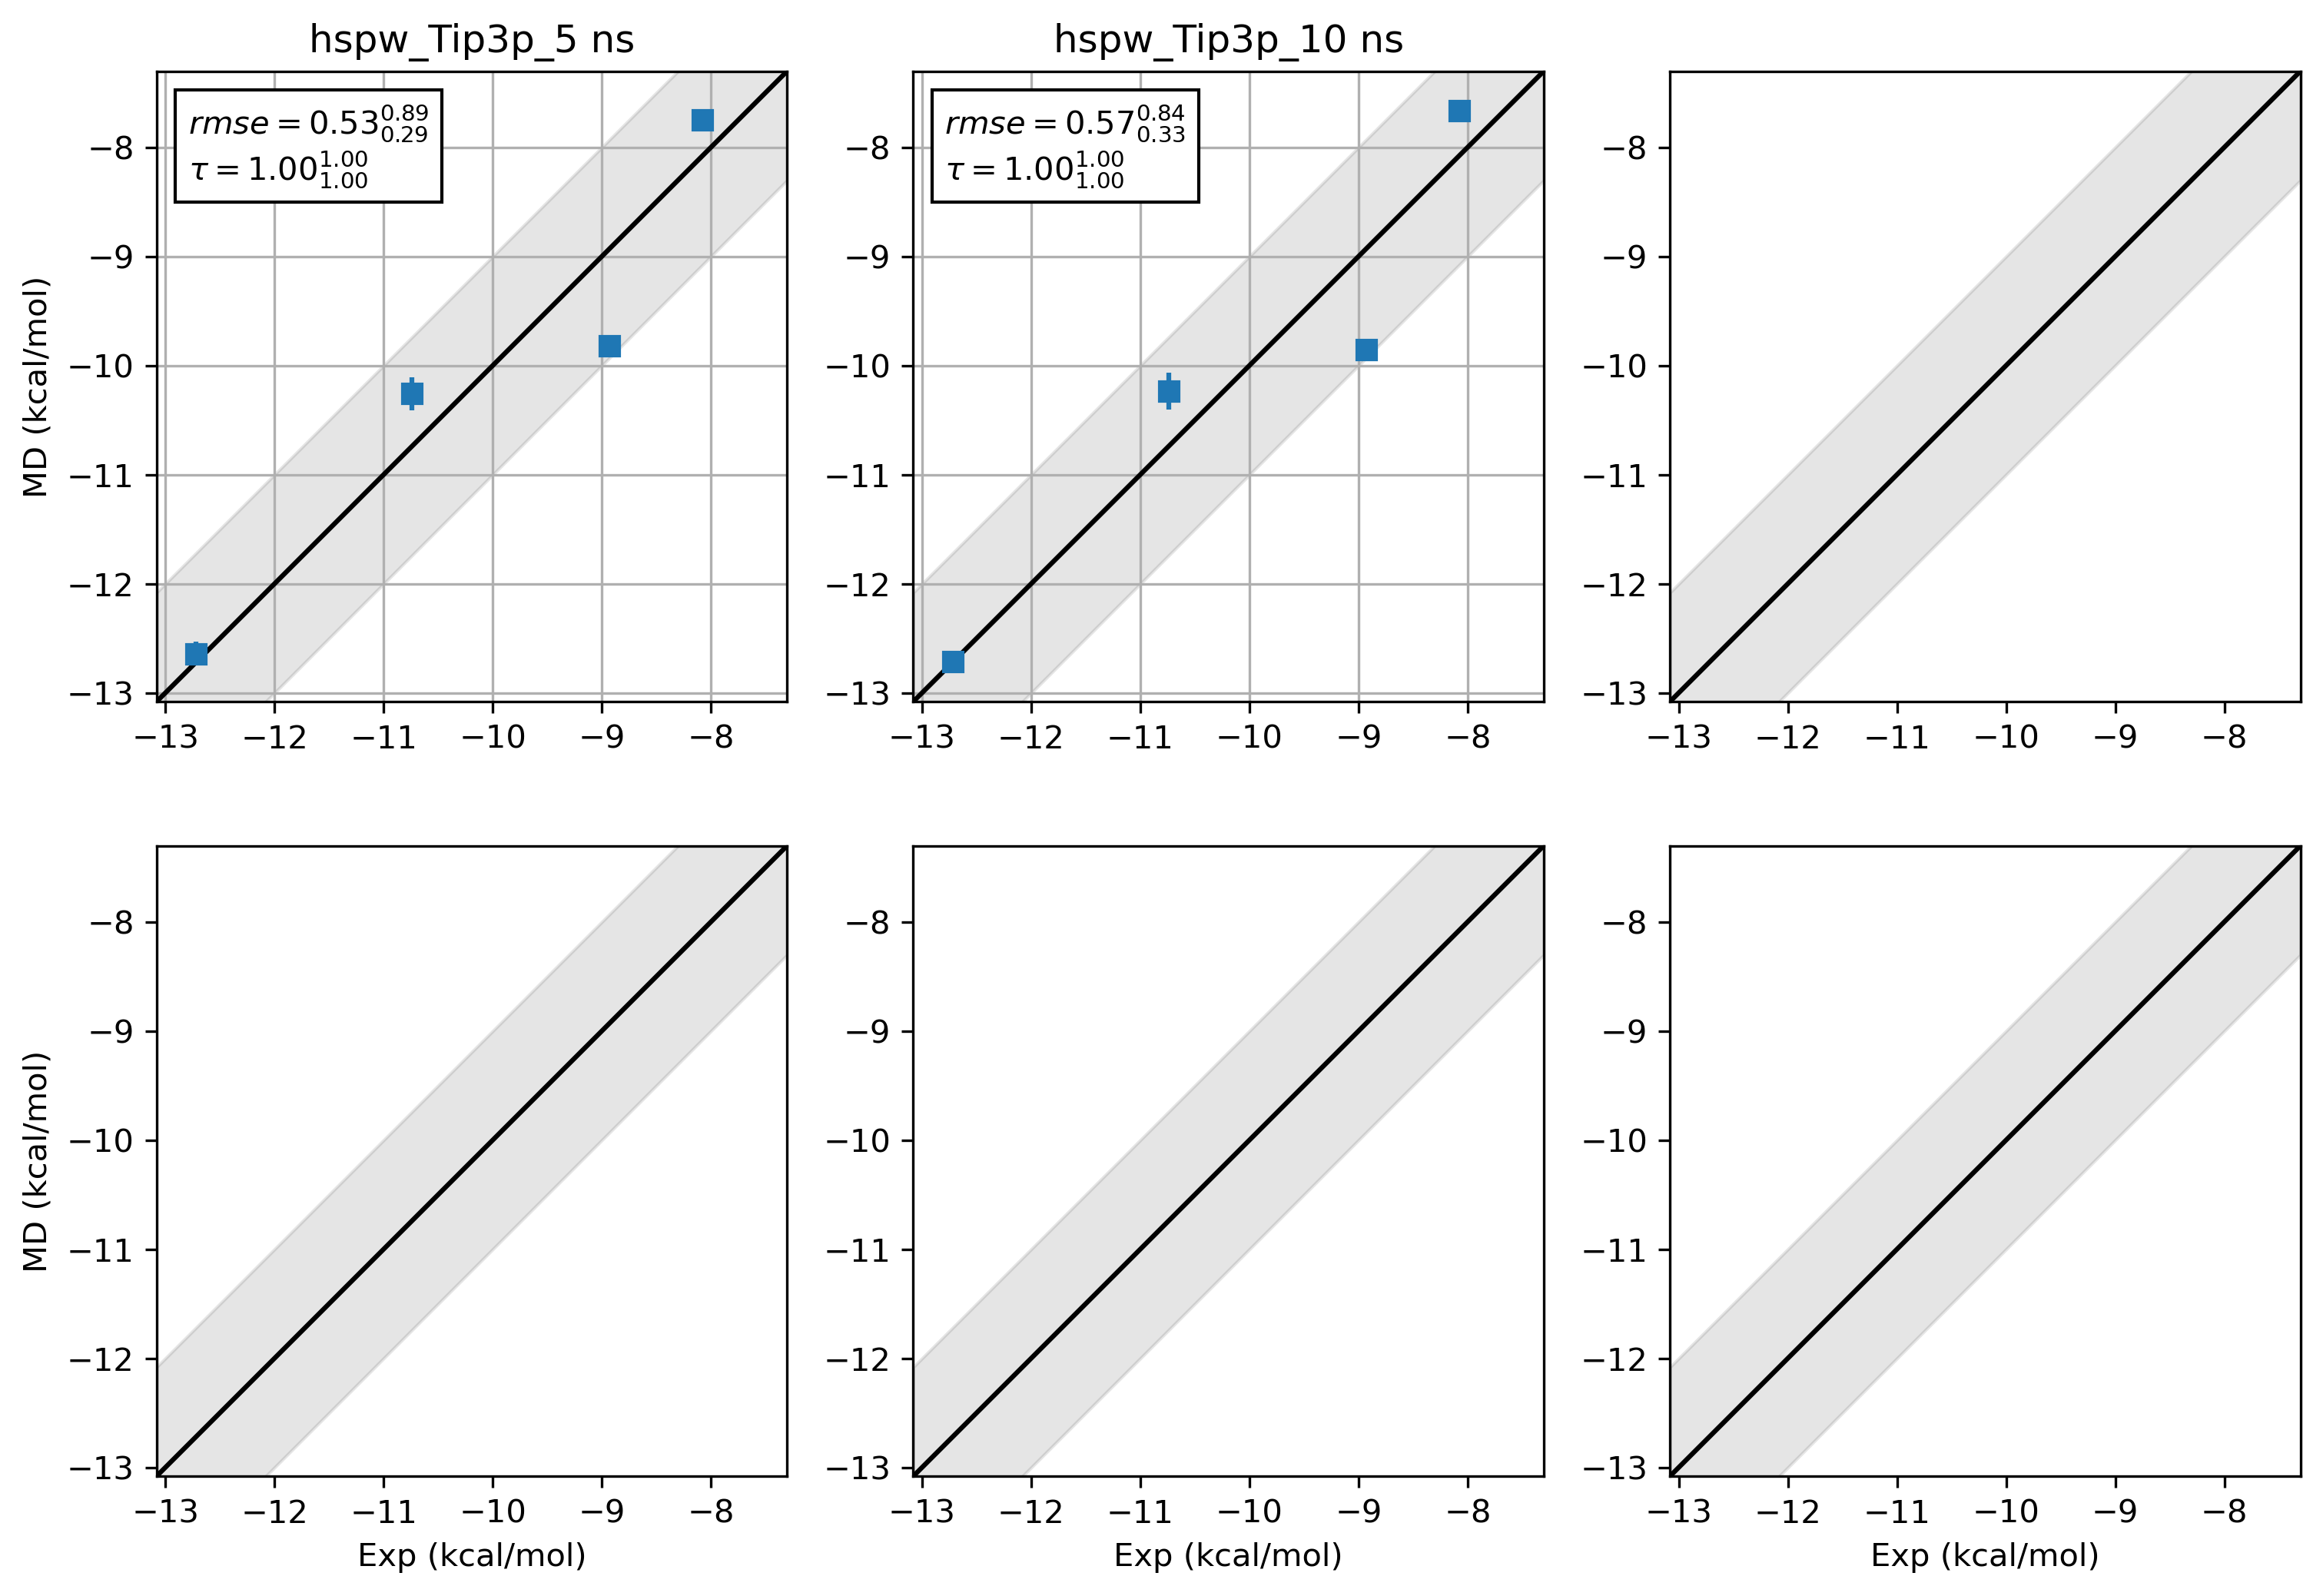

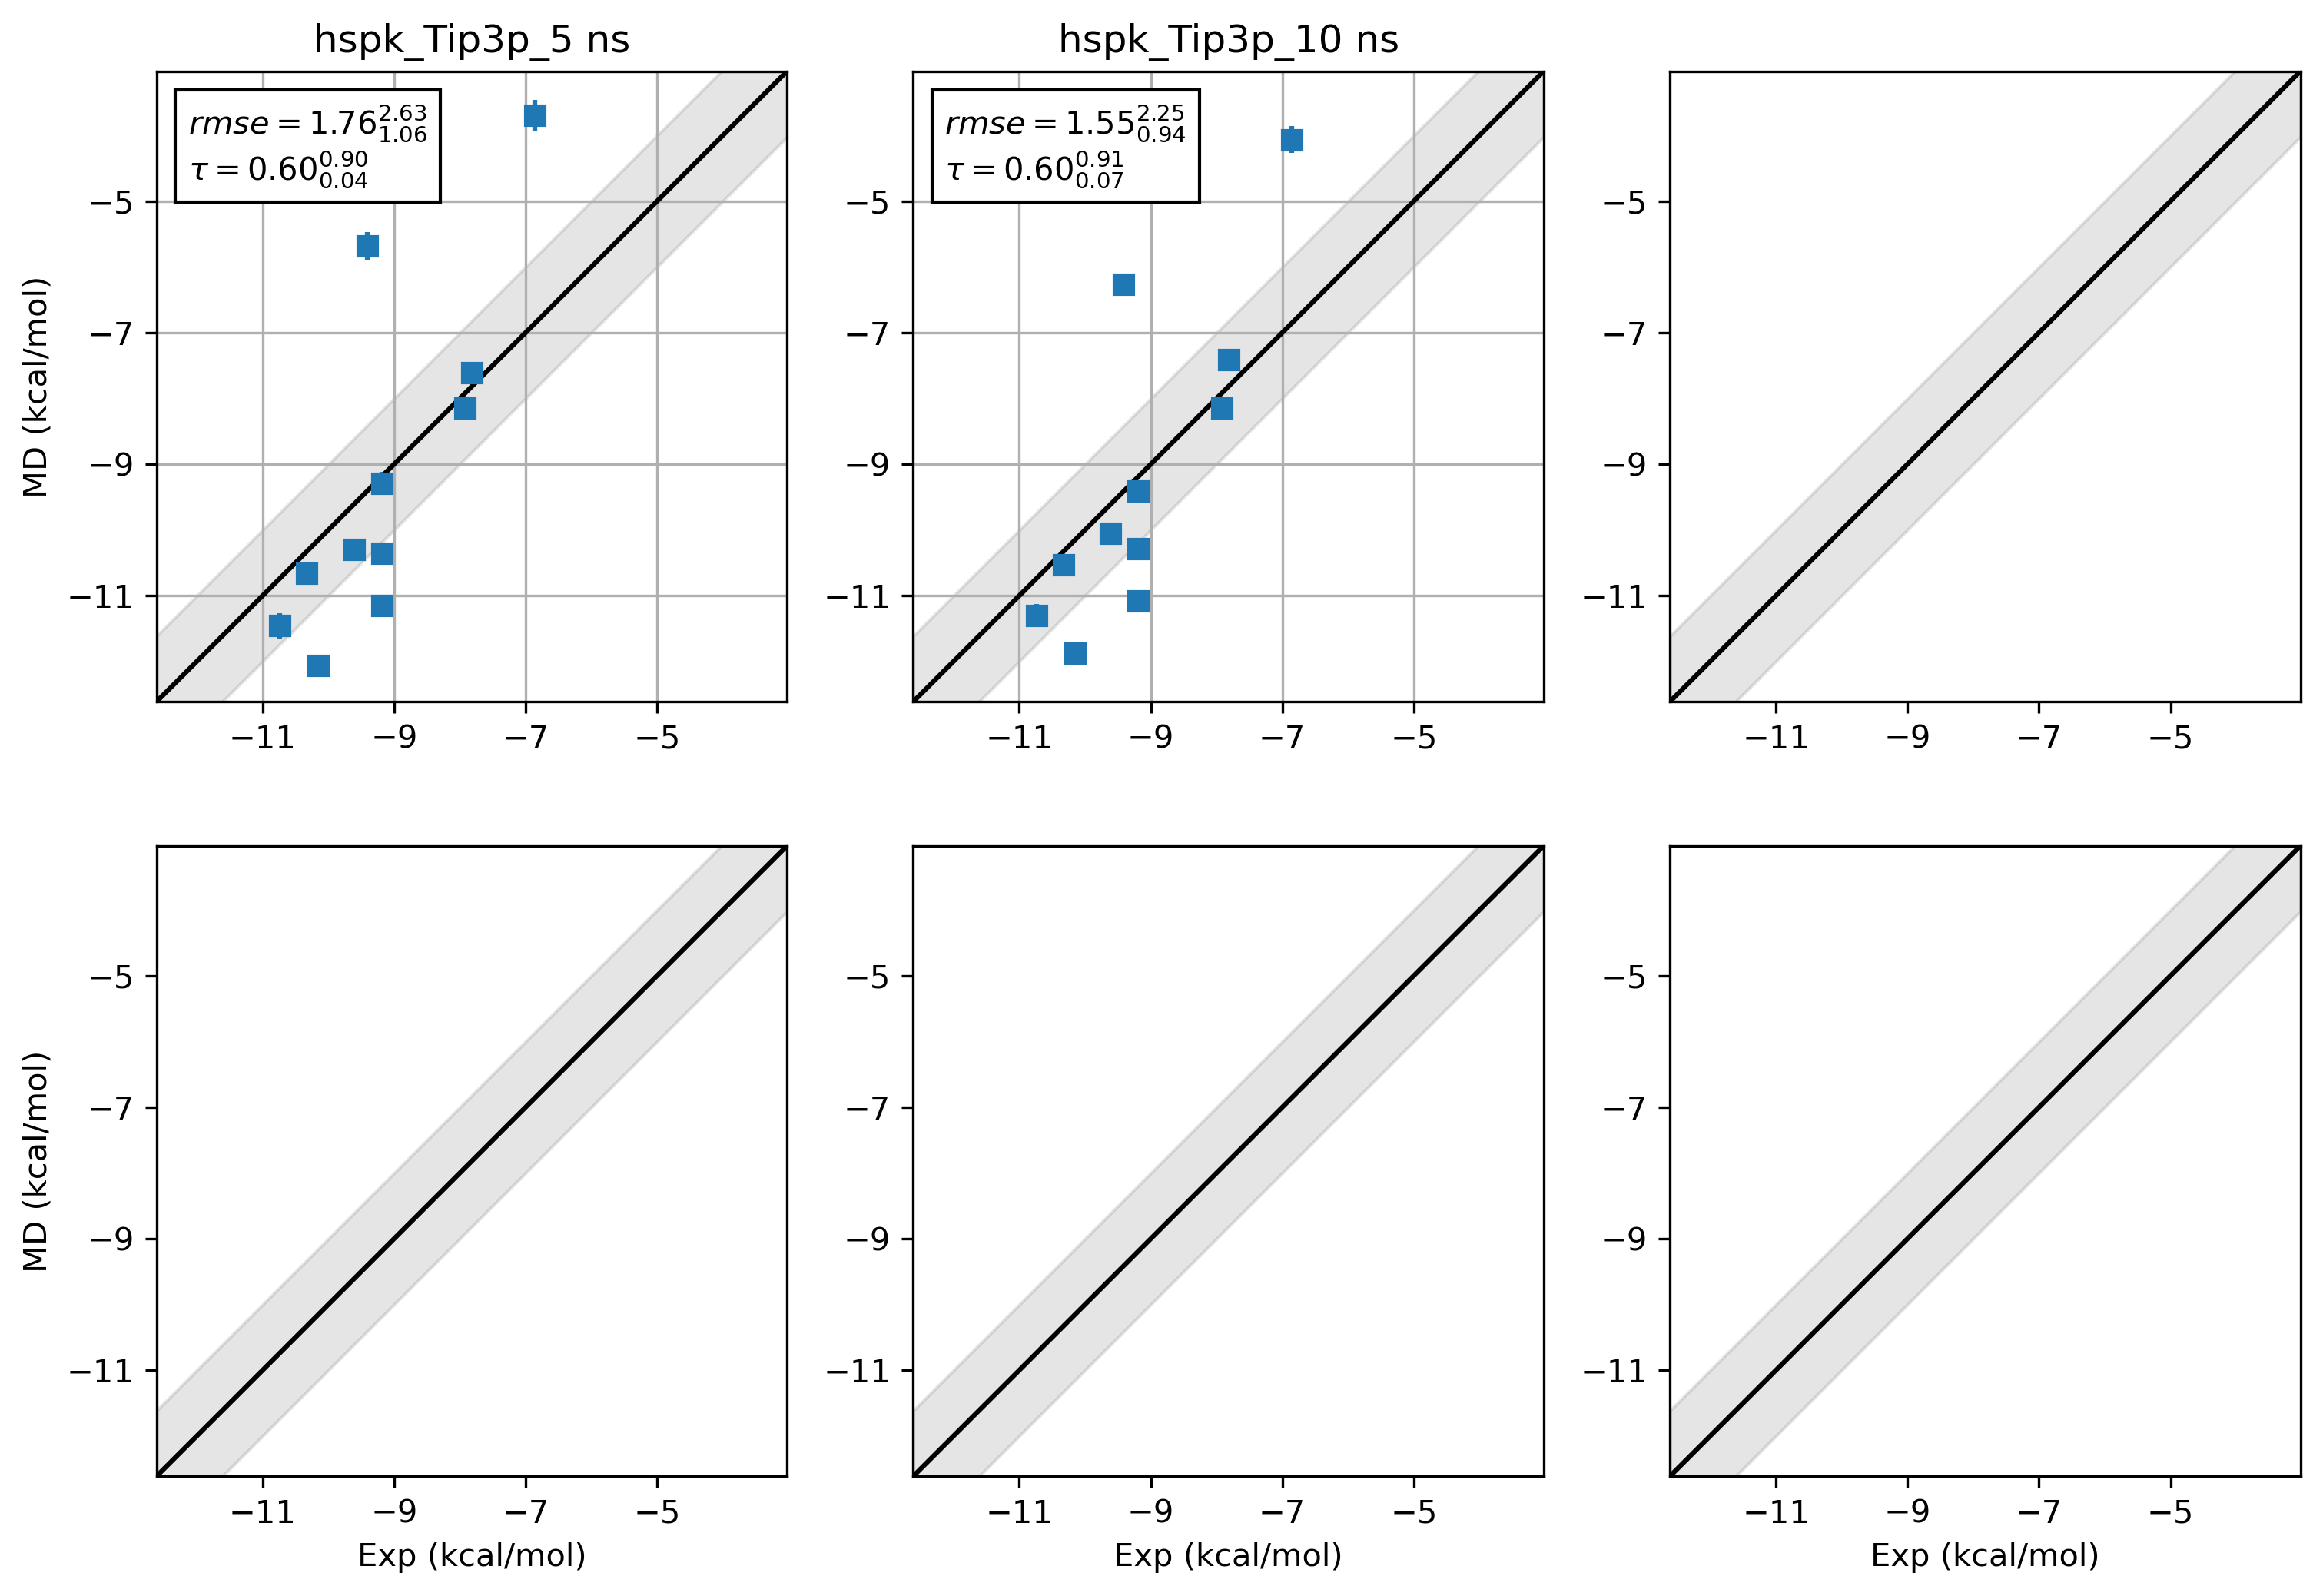

In [23]:
ff_title_dict = {
    "04_tip3p_REST2" : "Tip3p",
    "05_opc_REST2"   : "OPC",
}

for system in ["hspw", "hspk"]:
    fig, axes = plt.subplots(2,3,dpi=300, figsize=(12, 8))
    df_res_all = []
    prot = "GC_80l_40MD_31RE_200MD"
    for ff, ax_list in zip(["04_tip3p_REST2", "05_opc_REST2"], axes):
        df_res_all.append([])
        for (ax, sim_length) in zip(ax_list, [5, 10, 15]):
            name = f"{system}_{ff}_{prot}_{sim_length}ns"
            if name in dG_dict:
                df = dG_dict[name]
                df_res_all[-1].append(df)
                ax.errorbar(df["Exp_dG"], df["DG (kcal/mol)"], yerr = df["uncertainty (kcal/mol)"], marker='s', ls='none')
                ax.grid()
                ax.set_title(f"{system}_{ff_title_dict[ff]}_{sim_length} ns")
            else:
                ax.set_xlim(-10, -9)
                ax.set_ylim(-10, -9)
            
    (xmax, xmin), (ymax, ymin) = utils.uniform_xylim(axes)
    label_stat(df_res_all, axes)
    utils.add_gray_1kcal(axes, alpha=0.1)

    for ax in axes[-1]:
        ax.set_xlabel("Exp (kcal/mol)")
    for ax_list in axes:
        ax_list[0].set_ylabel("MD (kcal/mol)")
    
    fig.savefig(f"{system}_deltaG.png", bbox_inches='tight')

## 2.2. ΔΔG

In [24]:
ddG_df = ddG_dict["hspw_04_tip3p_REST2_GC_80l_40MD_31RE_200MD_10ns"]
ddG_df["Err"] = ddG_df["Exp_ddG"] - ddG_df["calc_ddG"]
ddG_df

,edge_name,calc_ddG,calc_ddG_err,Exp_ddG,Err
0,edge_1_to_4,2.872133,0.050847,3.79,0.917867
1,edge_4_to_3,2.201133,0.016828,0.85,-1.351133
2,edge_1_to_3,5.038667,0.165883,4.64,-0.398666
3,edge_1_to_2,2.462900,0.269682,1.98,-0.482900
4,edge_3_to_2,-2.427733,0.392655,-2.66,-0.232267
5,edge_2_to_4,0.444500,0.250205,1.81,1.365500
